In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("..")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
from tqdm.auto import tqdm

## tf

https://sebastianraschka.com/blog/2023/self-attention-from-scratch.html

In [4]:
sentence = 'Life is short, eat dessert first'

dc = {s:i for i,s in enumerate(sorted(sentence.replace(',', '').split()))}
print(dc)

{'Life': 0, 'dessert': 1, 'eat': 2, 'first': 3, 'is': 4, 'short': 5}


In [5]:
import torch

sentence_int = torch.tensor([dc[s] for s in sentence.replace(',', '').split()])
print(sentence_int)

tensor([0, 4, 5, 2, 1, 3])


In [6]:
torch.manual_seed(123)
embed = torch.nn.Embedding(6, 4)
embedded_sentence = embed(sentence_int).detach()

print(embedded_sentence)
print(embedded_sentence.shape)

tensor([[ 0.3374, -0.1778, -0.3035, -0.5880],
        [-0.7849, -1.4096, -0.4076,  0.7953],
        [ 0.9985,  0.2212,  1.8319, -0.3378],
        [-0.1606, -0.4015,  0.6957, -1.8061],
        [ 0.3486,  0.6603, -0.2196, -0.3792],
        [ 1.8960, -0.1750,  1.3689, -1.6033]])
torch.Size([6, 4])


In [7]:
torch.manual_seed(123)

d = embedded_sentence.shape[1]

d_q, d_k, d_v = 5, 5, 7

W_query = torch.nn.Parameter(torch.rand(d_q, d))
W_key = torch.nn.Parameter(torch.rand(d_k, d))
W_value = torch.nn.Parameter(torch.rand(d_v, d))

In [8]:
W_query.shape, embedded_sentence.shape

(torch.Size([5, 4]), torch.Size([6, 4]))

In [9]:
x_2 = embedded_sentence[1]
query_2 = W_query.matmul(x_2)
key_2 = W_key.matmul(x_2)
value_2 = W_value.matmul(x_2)

print(query_2.shape)
print(key_2.shape)
print(value_2.shape)

torch.Size([5])
torch.Size([5])
torch.Size([7])


In [10]:
queries = W_query.matmul(embedded_sentence.T).T
keys = W_key.matmul(embedded_sentence.T).T
values = W_value.matmul(embedded_sentence.T).T

print("queries.shape:", queries.shape)
print("keys.shape:", keys.shape)
print("values.shape:", values.shape)

queries.shape: torch.Size([6, 5])
keys.shape: torch.Size([6, 5])
values.shape: torch.Size([6, 7])


for a single observation

In [11]:
x_2 = embedded_sentence[1]
query_2 = W_query.matmul(x_2)
key_2 = W_key.matmul(x_2)
value_2 = W_value.matmul(x_2)

In [12]:
omega_2 = query_2.matmul(keys.T)
print(omega_2)

tensor([ 1.7991,  2.0504, -4.0754,  4.5862, -0.2397, -0.7732],
       grad_fn=<SqueezeBackward4>)


In [13]:
import torch.nn.functional as F

attention_weights_2 = F.softmax(omega_2 / d_k**0.5, dim=0)
print(attention_weights_2)

tensor([0.1566, 0.1752, 0.0113, 0.5445, 0.0629, 0.0496],
       grad_fn=<SoftmaxBackward0>)


In [14]:
W_value.shape

torch.Size([7, 4])

In [15]:
values.shape

torch.Size([6, 7])

In [16]:
context_vector_2 = attention_weights_2.matmul(values)

print(values.shape)
print(context_vector_2.shape)
print(context_vector_2)

torch.Size([6, 7])
torch.Size([7])
tensor([-0.9881, -0.7193, -0.8198, -0.2363, -0.3548, -0.6055, -0.5877],
       grad_fn=<SqueezeBackward4>)


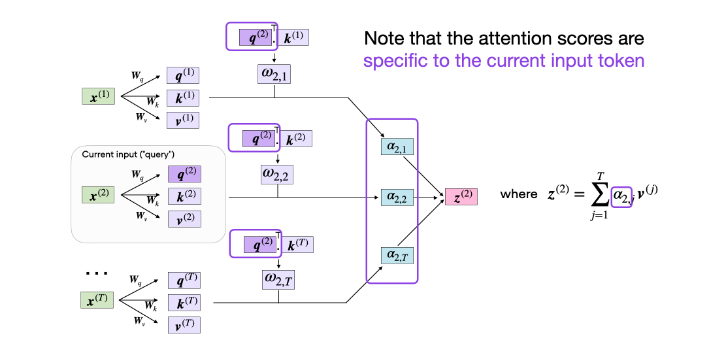

In [17]:
# attention_weights = keys.T.matmul(queries).T

unnorm_attention_weights = queries.matmul(keys.T)

In [18]:
unnorm_attention_weights

tensor([[ 1.0418,  1.5747, -3.3146,  2.4804, -0.1719, -1.5238],
        [ 1.7991,  2.0504, -4.0754,  4.5862, -0.2397, -0.7732],
        [-1.5021, -2.3332,  4.6376, -3.5735,  0.3017,  2.0320],
        [ 2.3717,  3.5021, -7.6047,  5.7713, -0.3497, -3.5458],
        [-0.5622, -0.4945,  0.9795, -1.5021,  0.0521, -0.0882],
        [ 0.5737,  0.7771, -1.9304,  1.3730, -0.0330, -0.9634]],
       grad_fn=<MmBackward0>)

In [19]:
attention_weights = F.softmax(unnorm_attention_weights / d_k**0.5, dim=1)

In [20]:
attention_weights

tensor([[0.1918, 0.2434, 0.0273, 0.3650, 0.1115, 0.0609],
        [0.1566, 0.1752, 0.0113, 0.5445, 0.0629, 0.0496],
        [0.0404, 0.0279, 0.6291, 0.0160, 0.0905, 0.1962],
        [0.1314, 0.2178, 0.0015, 0.6010, 0.0389, 0.0093],
        [0.1383, 0.1425, 0.2755, 0.0908, 0.1820, 0.1709],
        [0.1954, 0.2141, 0.0638, 0.2794, 0.1490, 0.0983]],
       grad_fn=<SoftmaxBackward0>)

In [21]:
for j in range(6):
    a = F.softmax(unnorm_attention_weights[j] / d_k**0.5, dim=0)
    print(a)

tensor([0.1918, 0.2434, 0.0273, 0.3650, 0.1115, 0.0609],
       grad_fn=<SoftmaxBackward0>)
tensor([0.1566, 0.1752, 0.0113, 0.5445, 0.0629, 0.0496],
       grad_fn=<SoftmaxBackward0>)
tensor([0.0404, 0.0279, 0.6291, 0.0160, 0.0905, 0.1962],
       grad_fn=<SoftmaxBackward0>)
tensor([0.1314, 0.2178, 0.0015, 0.6010, 0.0389, 0.0093],
       grad_fn=<SoftmaxBackward0>)
tensor([0.1383, 0.1425, 0.2755, 0.0908, 0.1820, 0.1709],
       grad_fn=<SoftmaxBackward0>)
tensor([0.1954, 0.2141, 0.0638, 0.2794, 0.1490, 0.0983],
       grad_fn=<SoftmaxBackward0>)


In [22]:
z = attention_weights.matmul(values)

In [23]:
print(z.shape)

torch.Size([6, 7])


In [40]:
z

tensor([[-0.7218, -0.5704, -0.6733, -0.2535, -0.3824, -0.5305, -0.4826],
        [-0.9881, -0.7193, -0.8198, -0.2363, -0.3548, -0.6055, -0.5877],
        [ 0.4959,  0.7714,  1.6358,  1.2920,  0.9780,  0.6345,  0.6342],
        [-1.0624, -0.8349, -1.0408, -0.4040, -0.4833, -0.7684, -0.6821],
        [-0.0410,  0.1619,  0.5644,  0.5515,  0.3053,  0.1617,  0.1187],
        [-0.5647, -0.3948, -0.3745, -0.0573, -0.2218, -0.3375, -0.3398]],
       grad_fn=<MmBackward0>)

## export weights to file

In [24]:
from pathlib import Path

DATA_DIR = Path("../data/vitis_hls")

In [25]:
to_export = [
    (W_query, 'W_query'),
    (W_key, 'W_key'),
    (W_value, 'W_value'),
    (z, 'z'),
    (embedded_sentence, 'x')
]

In [26]:
def array_to_file(p):
    a = p[0].detach().numpy()
    filename = p[1]
    with open(DATA_DIR / filename, 'w') as f:
        a.tofile(f, sep=' ')

In [27]:
for p in to_export:
    array_to_file(p)

In [39]:
z

tensor([[-0.7218, -0.5704, -0.6733, -0.2535, -0.3824, -0.5305, -0.4826],
        [-0.9881, -0.7193, -0.8198, -0.2363, -0.3548, -0.6055, -0.5877],
        [ 0.4959,  0.7714,  1.6358,  1.2920,  0.9780,  0.6345,  0.6342],
        [-1.0624, -0.8349, -1.0408, -0.4040, -0.4833, -0.7684, -0.6821],
        [-0.0410,  0.1619,  0.5644,  0.5515,  0.3053,  0.1617,  0.1187],
        [-0.5647, -0.3948, -0.3745, -0.0573, -0.2218, -0.3375, -0.3398]],
       grad_fn=<MmBackward0>)